In [1]:
# initialize stuff
import sys
import logging
import importlib

import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.optimize import curve_fit

# import theory stuff

HOME_DIR = "/Users/oliver/Documents/p5control-bluefors-evaluation"
sys.path.append(HOME_DIR)

import superconductivity.api as sc

from superconductivity.style.cpd4 import cmap, colors

from superconductivity.utilities.functions import bin_y_over_x, oversample

from superconductivity.utilities.constants import G_0_muS

In [2]:
# Initial guessing parameter
tau_0_arbu: float = 0.18877592218372993
Delta_0_meV: float = 0.19345000789195935
Gamma_0_meV: float = 0.005066874981090785

tau_0_err_arbu: float = 8.141661166363163e-06
Delta_0_err_meV: float = 0.001046070192372882
Gamma_0_err_meV: float = 0.00022303789162508994

# --- paramters ---
# τ = 0.18877592218372993 (8.141661166363163e-06)
# Δ = 0.19345000789195935 (0.001046070192372882) mV
# Γ = 0.005066874981090785 (0.00022303789162508994) mV

T_0_K: float = 0.08
# Data
nu_GHz = 13.6  # n = perfect, slight gap closing
A_mV: NDArray[np.float64] = np.arange(0, 1.5, 0.002, dtype="float64")

V: NDArray[np.float64] = np.linspace(-9.5, 9.5, 801, dtype="float64")
V_mV = V * Delta_0_meV
V_off_range_mV: NDArray[np.float64] = np.linspace(-0.045, 0.045, 451, dtype="float64")

I_nA: NDArray[np.float64] = np.linspace(-30, 30, 601, dtype="float64")
I_off_range_nA: NDArray[np.float64] = np.linspace(-0.35, 0.35, 701, dtype="float64")

# exp_data evaluation
sampling_rate: float = 13.7
window_length: int = 0

# interesting Amplitudes
A_lim_mV: tuple[float, float] = (0, 705)  # mV
A_interest_mV: list[float] = [0, 100, 250, 400]  # mV

# PAT parameter
# nu_GHz: float = 7.8  # n = many, gap closing
# nu_GHz: float = 8.0  # n = inf, ever so slight gap closing
# nu_GHz: float = 15.0 # n = 2, crap
# nu_GHz: float = 18.3  # n = okay, slight gap closing
# nu_GHz: float = 19.3 # n = 3, crap

G_N = tau_0_arbu


def calibration_A(x_data: NDArray[np.float64], eta: float, A_off: float):
    A_cal = A_off + eta * x_data
    return A_cal


def calibration_T(
    x_data: NDArray[np.float64], T_base: float, T_off: float, alpha: float
):
    x_data = T_off + alpha * x_data
    return np.where(x_data <= T_base, T_base, x_data)


eta = 0.002173  # (3)
A_off = -6.2e-3  # (13) mV
T_base = 0.0806  # (46) K
T_off = -0.685  # (194) K
alpha = 2.6811  # (458)

In [3]:
# # Get exp data
# from utilities.ivevaluation import IVEvaluation

# importlib.reload(sys.modules["utilities.ivevaluation"])
# logger = logging.getLogger()
# logger.setLevel(level=logging.WARNING)

# eva = IVEvaluation()
# eva.file_directory = "/Users/oliver/Documents/measurement data/"
# eva.file_folder = "25 04 OI-25c-09/"
# eva.file_name = "OI-25c-09 2025-05-02 unbroken stripline irradiation studies 0.hdf5"
# eva.sub_folder = ""

# eva.setAmplifications(1000, 1000)
# eva.setV(
#     voltage_minimum=np.min(V_mV) * 1e-3,
#     voltage_maximum=np.max(V_mV) * 1e-3,
#     voltage_bins=V_mV.shape[0] - 1,
# )
# eva.eva_current = True
# eva.setI(
#     current_minimum=np.min(I_nA) * 1e-9,
#     current_maximum=np.max(I_nA) * 1e-9,
#     current_bins=I_nA.shape[0] - 1,
# )
# eva.eva_voltage = True

# eva.downsample_frequency = sampling_rate

# eva.title = f"amplitude at {nu_GHz:.1f}GHz"
# eva.setMeasurement(f"vna_amplitudes_{nu_GHz:.1f}000GHz")
# eva.setKeys(index_0=-6, index_1=-1, norm=1e0, to_pop="no_irradiation")
# eva.addKey("no_irradiation", 0)
# eva.addKey("no_irradiation", 0.005)
# (eva.up_sweep,) = eva.getMaps(
#     [1], y_lim=tuple(np.array(A_lim_mV) * 1e-3), skip=(20, None)
# )
# eva.saveData()

# # logger.setLevel(level=logging.INFO)
# # eva.showMeasurements()
# # eva.showKeys()

# # plot and load exp data
# %matplotlib inline
# from utilities.ivplot import IVPlot
# importlib.reload(sys.modules["utilities.ivplot"])
# logger = logging.getLogger()
# logger.setLevel(level=logging.WARNING)

# eva = IVPlot()
# eva.title = f"amplitude at {nu_GHz:.1f}GHz"
# eva.sub_folder = ""
# eva.loadData()
# eva.to_plot = eva.up_sweep
# eva.title_of_plot = "Up Sweep"
# eva.y_characters = [r"$A$", "V"]
# eva.dvdi_norm = (1e3, 'k')
# eva.didv_c_lim = (0, 0.4)
# eva.dvdi_c_lim = (0, 0.4e6)
# if window_length >2:
#     eva.smoothing = True
#     eva.window_length = window_length
# else:
#     eva.smoothing = False
# eva.plot_T = False
# eva.plot_dvdis = True
# eva.plot_didvs = True
# eva.plot_all()

(base) ... BaseClass initialized.
(base eva) ... BaseEvaluation initialized.
(iv eva) ... IVEvaluation initialized.
(base) amplitude at 13.6GHz
(base) loadData()
100%|██████████| 141/141 [01:39<00:00,  1.41it/s]
(base) amplitude at 13.6GHz offset_correction
(base) saveData()


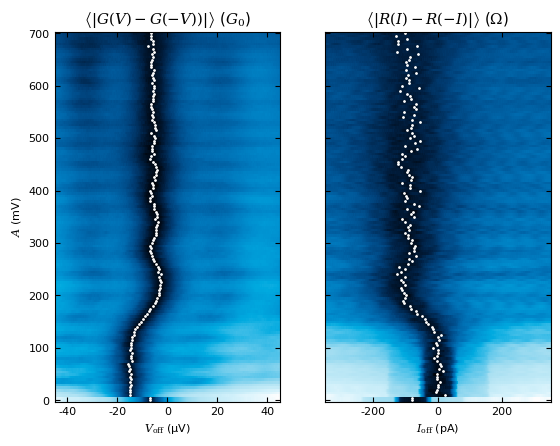

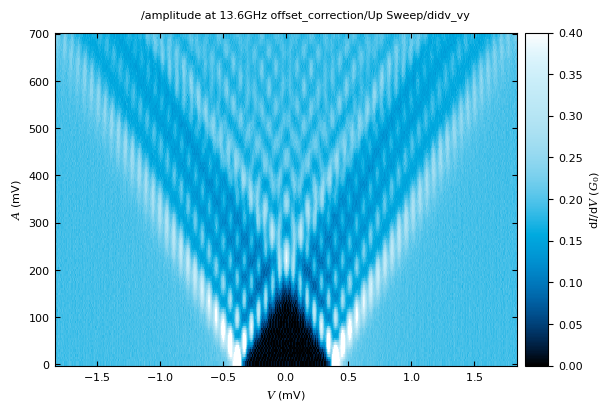

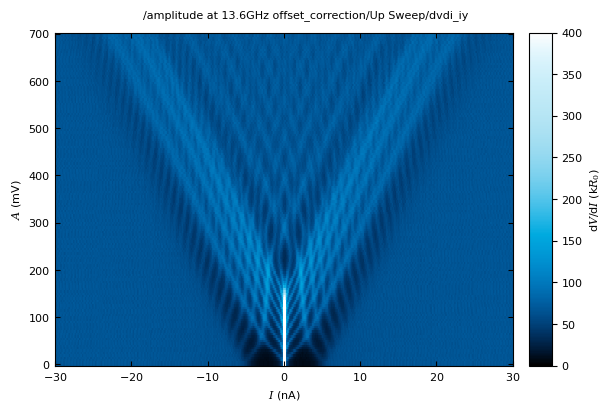

In [4]:
# Offset correction

# region offset definitions
import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)


def bin_y_over_x_jax(x, y, x_bins):
    """
    1D binning with JAX-safe scatter (no boolean indexing).
    """
    edges = (x_bins[:-1] + x_bins[1:]) / 2
    edges = jnp.concatenate(
        [
            jnp.array([x_bins[0] - (edges[0] - x_bins[0])]),
            edges,
            jnp.array([x_bins[-1] + (x_bins[-1] - edges[-1])]),
        ]
    )

    idx = jnp.digitize(x, edges) - 1  # shape (N,)

    # Clip indices to [0, M-1], out-of-range will produce 0 in sum but count will be 0
    idx_clipped = jnp.clip(idx, 0, x_bins.shape[0] - 1)
    mask = (idx >= 0) & (idx < x_bins.shape[0])
    mask = mask.astype(x.dtype)

    # Sum and count using scatter_add
    sum_y = jnp.zeros(x_bins.shape[0], dtype=y.dtype)
    count = jnp.zeros(x_bins.shape[0], dtype=y.dtype)

    sum_y = sum_y.at[idx_clipped].add(y * mask)
    count = count.at[idx_clipped].add(mask)

    return jnp.where(count > 0, sum_y / count, jnp.nan)


# vectorized over offsets
def bin_y_over_x_offsets(x, y, x_bins, x_off):
    """
    Bin I-V curves shifted by multiple offsets in one call.

    Parameters
    ----------
    x : (N,) x-values
    y : (N,) y_values
    x_bins : (M,) bin centers
    x_off : (K,) offsets

    Returns
    -------
    binned : (M, K) binned currents per offset
    """

    # Define a function for a single offset
    def single_offset_bin(x_shift):
        return bin_y_over_x_jax(x - x_shift, y, x_bins)

    # vmap over all offsets
    binned = jax.vmap(single_offset_bin)(x_off)  # shape (K, M)

    return binned.T  # return shape (M, K)


# endregion

# region initialization

from utilities.ivevaluation import IVEvaluation

importlib.reload(sys.modules["utilities.ivevaluation"])
eva = IVEvaluation()
eva.title = f"amplitude at {nu_GHz:.1f}GHz"
eva.sub_folder = ""
eva.loadData()

dV_off_mV = V_off_range_mV[1] - V_off_range_mV[0]
dI_off_nA = I_off_range_nA[1] - I_off_range_nA[0]

A_out_mV: NDArray[np.float64] = np.array(eva.mapped["y_axis"], dtype="float64") * 1e3
dA_out_mV = A_out_mV[1] - A_out_mV[0]
T_exp_K: NDArray[np.float64] = np.array(eva.up_sweep["temperature"], dtype="float64")

dG_err_G0 = np.full(
    (A_out_mV.shape[0], V_off_range_mV.shape[0]), np.nan, dtype="float64"
)
dR_err_Ohm = np.full(
    (A_out_mV.shape[0], I_off_range_nA.shape[0]), np.nan, dtype="float64"
)

V_off_mV = np.full((A_out_mV.shape[0]), np.nan, dtype="float64")
I_off_nA = np.full((A_out_mV.shape[0]), np.nan, dtype="float64")

I_exp_nA = np.full((A_out_mV.shape[0], V_mV.shape[0]), np.nan, dtype="float64")
G_exp_G0 = np.full((A_out_mV.shape[0], V_mV.shape[0]), np.nan, dtype="float64")
V_exp_mV = np.full((A_out_mV.shape[0], I_nA.shape[0]), np.nan, dtype="float64")
R_exp_Ohm = np.full((A_out_mV.shape[0], I_nA.shape[0]), np.nan, dtype="float64")
# endregion

# region big loop
for j_a, a_mV in enumerate(tqdm(A_out_mV)):

    v, i = eva.up_sweep["iv_tuples"][j_a][0:2]
    v_mV = np.array(v, dtype="float64") * 1e3
    i_nA = np.array(i, dtype="float64") * 1e9

    v_mV, i_nA = oversample(v_mV, i_nA, upsample=10)

    i_tmp = bin_y_over_x_offsets(v_mV, i_nA, V_mV, V_off_range_mV)
    g_tmp = np.gradient(i_tmp, V_mV, axis=0)
    g_err = np.mean(np.abs(g_tmp - np.flip(g_tmp, axis=0)), axis=0)
    v_off = V_off_range_mV[np.argmin(g_err)]

    v_tmp = bin_y_over_x_offsets(i_nA, v_mV, I_nA, I_off_range_nA)
    r_tmp = np.gradient(v_tmp, I_nA, axis=0)
    r_err = np.mean(np.abs(r_tmp - np.flip(r_tmp, axis=0)), axis=0)
    i_off = I_off_range_nA[np.argmin(r_err)]

    i_exp = bin_y_over_x(v_mV - v_off, i_nA - i_off, V_mV)
    g_exp = np.gradient(i_exp, V_mV) / G_0_muS

    v_exp = bin_y_over_x(i_nA - i_off, v_mV - v_off, I_nA)
    r_exp = np.gradient(v_exp, I_nA) * 1e6

    dG_err_G0[j_a, :] = g_err
    dR_err_Ohm[j_a, :] = r_err

    V_off_mV[j_a] = v_off
    I_off_nA[j_a] = i_off

    I_exp_nA[j_a, :] = i_exp
    G_exp_G0[j_a, :] = g_exp
    V_exp_mV[j_a, :] = v_exp
    R_exp_Ohm[j_a, :] = r_exp
# endregion

# region relocalization
eva.mapped["voltage_axis"] = V_mV * 1e-3
eva.mapped["current_axis"] = I_nA * 1e-9
eva.up_sweep["current"] = I_exp_nA * 1e-9
eva.up_sweep["differential_conductance"] = G_exp_G0
eva.up_sweep["voltage"] = V_exp_mV * 1e-3
eva.up_sweep["differential_resistance"] = R_exp_Ohm
eva.up_sweep["dG_err_G0"] = dG_err_G0
eva.up_sweep["dR_err_Ohm"] = dR_err_Ohm
eva.up_sweep["V_off_mV"] = V_off_mV * 1e-3
eva.up_sweep["I_off_nA"] = I_off_nA * 1e-9


eva.title = f"amplitude at {nu_GHz:.1f}GHz offset_correction"
eva.saveData()
# endregion

# region plot offset errors
fig, [ax_i, ax_v] = plt.subplots(1, 2, num=100, sharey=True)

ax_i.imshow(
    dG_err_G0,
    cmap=cmap(),
    aspect="auto",
    origin="lower",
    interpolation="none",
    extent=(
        (V_off_range_mV[0] - dV_off_mV / 2) * 1e3,
        (V_off_range_mV[-1] + dV_off_mV / 2) * 1e3,
        A_out_mV[0] - dA_out_mV / 2,
        A_out_mV[-1] + dA_out_mV / 2,
    ),
)
ax_i.plot(V_off_mV * 1e3, A_out_mV, ".", color="w", ms=2)

ax_v.imshow(
    dR_err_Ohm,
    cmap=cmap(),
    aspect="auto",
    origin="lower",
    interpolation="none",
    extent=(
        (I_off_range_nA[0] - dI_off_nA / 2) * 1e3,
        (I_off_range_nA[-1] + dI_off_nA / 2) * 1e3,
        A_out_mV[0] - dA_out_mV / 2,
        A_out_mV[-1] + dA_out_mV / 2,
    ),
)
ax_v.plot(I_off_nA * 1e3, A_out_mV, ".", color="w", ms=2)

ax_i.set_ylabel("$A$ (mV)")
ax_i.set_xlabel("$V_\\mathrm{off}$ (µV)")
ax_v.set_xlabel("$I_\\mathrm{off}$ (pA)")


for ax in [ax_i, ax_v]:
    ax.tick_params(
        direction="in",  # Ticks nach innen
        top=True,  # obere Ticks ein
        bottom=True,  # untere Ticks ein
        left=True,  # linke Ticks ein
        right=True,  # rechte Ticks ein
        which="both",  # sowohl Major- als auch Minor-Ticks
    )

ax_i.set_title("$\\left\\langle|G(V) - G(-V))|\\right\\rangle$ ($G_0$)")
ax_v.set_title("$\\left\\langle|R(I) - R(-I)|\\right\\rangle$ ($\\Omega$)")
# endregion

# region plot and load offset_corrected data
from utilities.ivplot import IVPlot

importlib.reload(sys.modules["utilities.ivplot"])
logger = logging.getLogger()
logger.setLevel(level=logging.WARNING)

eva = IVPlot()
eva.title = f"amplitude at {nu_GHz:.1f}GHz offset_correction"
eva.sub_folder = ""
eva.loadData()

eva.to_plot = eva.up_sweep
eva.title_of_plot = "Up Sweep"
eva.y_characters = [r"$A$", "V"]
eva.dvdi_norm = (1e3, "k")
eva.didv_c_lim = (0, 0.4)
eva.dvdi_c_lim = (0, 0.4e6)
if window_length > 2:
    eva.smoothing = True
    eva.window_length = window_length
else:
    eva.smoothing = False
eva.plot_T = False
eva.plot_dvdis = True
eva.plot_didvs = True
eva.plot_all()
# endregion

index: 0, A_out_mV: 0
# Model: 'dynes+pat'
# Optimizer: 'curve_fit'

# --- paramters ---
# τ = 0.18876385533913095 (2.2584159397144354e-05)
# T = 0.2360352436712973 (0.10001806373571326) K
# Δ = 0.1955640380717814 (0.0004735824695815501) mV
# Γ = 0.0040235505684822455 (6.145347724331878e-05) mV
# A = 0.0 mV
# ν = 13.6 GHz

# --- input ---
# solution = fit_current(
#     V_mV=V_mV,
#     I_nA=I_nA,
#     G_N = (0.18900, (0.10000, 0.30000), False),
#     T_K = (0.08060, (0.00000, 1.20000), False),
#     Delta_mV = (0.19600, (0.19000, 0.20000), False),
#     Gamma_mV = (0.00400, (0.00010, 0.03000), False),
#     A_mV = (0.00000, (0.00000, 1.00000), True),
#     nu_GHz = (13.60, (12.24, 14.96), True),
#     model="dynes+pat",
#     optimizer="curve_fit",
# )
index: 20, A_out_mV: 100
# Model: 'dynes+pat'
# Optimizer: 'curve_fit'

# --- paramters ---
# τ = 0.18899330815024684 (1.3743400827506312e-05)
# T = 0.006795126949152018 (0.38631611447476444) K
# Δ = 0.19605213379863046 (8.428774499547

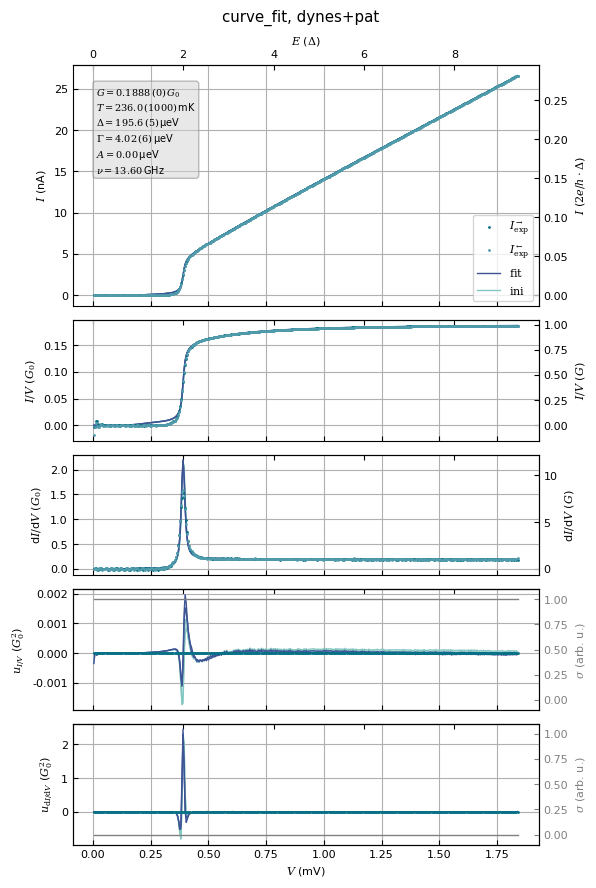

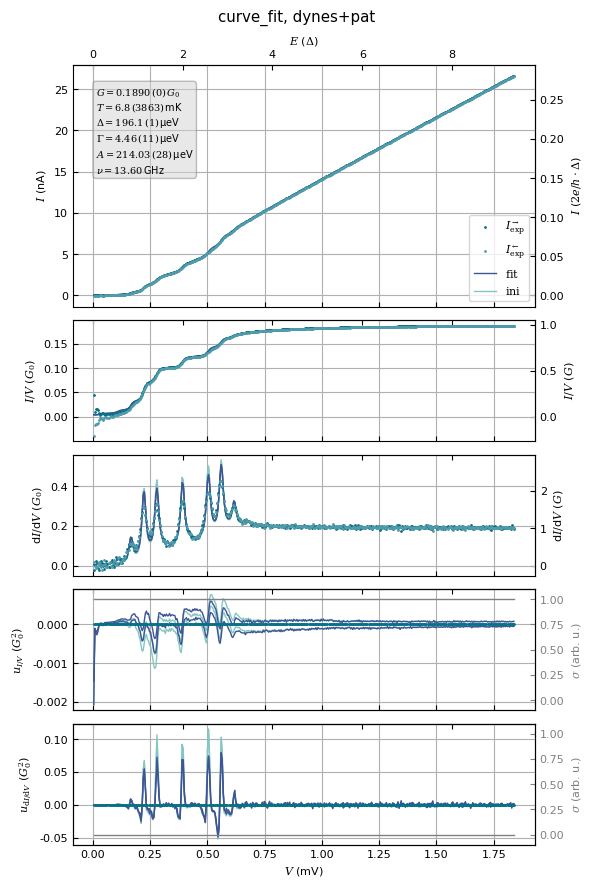

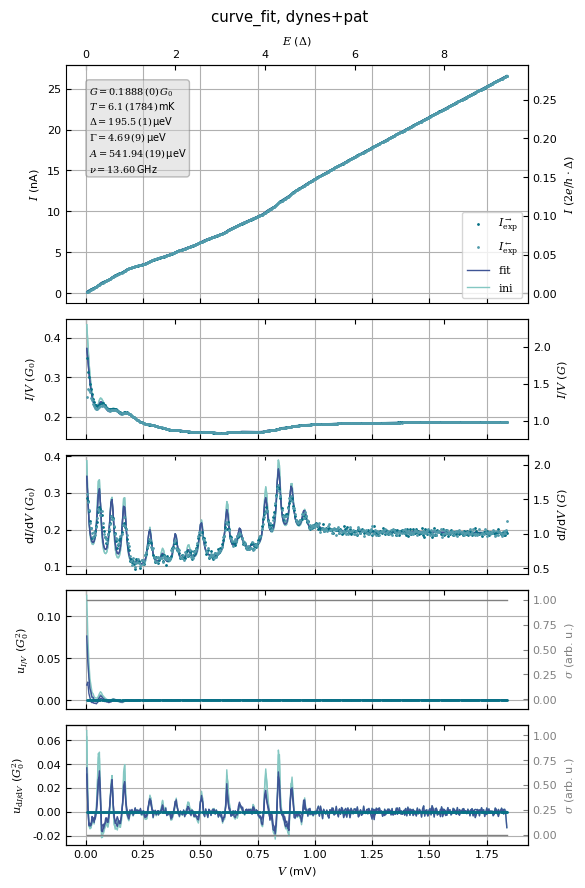

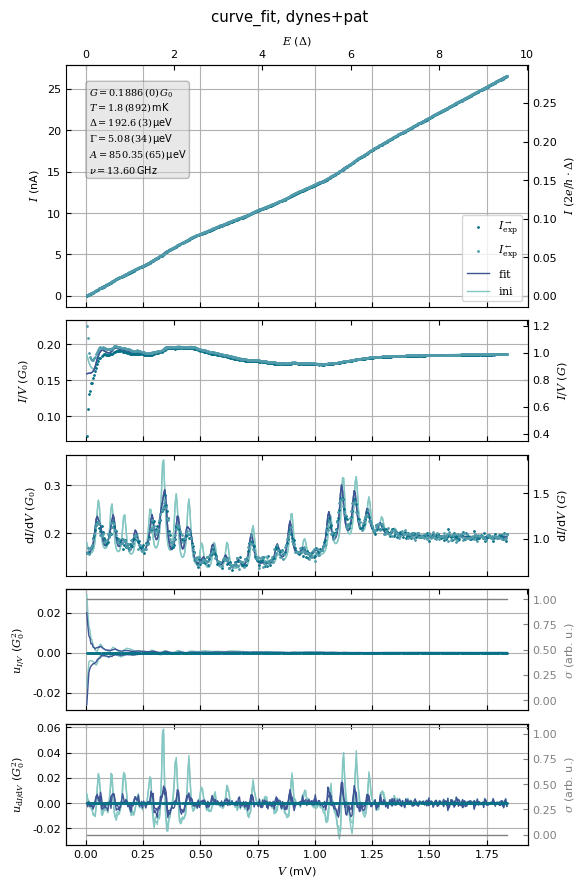

In [5]:
# Test fit one curve
from superconductivity.optimizers.fit_pat import fit_I_nA
from superconductivity.optimizers.show_fitting import show_fitting, show_stats

importlib.reload(sys.modules["superconductivity.optimizers.fit_pat"])
importlib.reload(sys.modules["superconductivity.optimizers.show_fitting"])


A_indices = []
for i, A_in in enumerate(A_interest_mV):
    index = np.argmin(np.abs(A_out_mV - A_in))

    print(f"index: {index}, A_out_mV: {A_in}")

    if A_in == 0:
        solution = fit_I_nA(
            V_mV=V_mV,
            I_nA=I_exp_nA[index, :],
            G_N=(0.189, (0.1, 0.3), False),
            T_K=(
                calibration_T(T_exp_K[i], T_base=T_base, T_off=T_off, alpha=alpha),
                (0.0, 1.2),
                False,
            ),
            Delta_meV=(0.196, (0.190, 0.2), False),
            gamma_meV=(0.004, (1e-4, 30e-3), False),
            A_mV=(0.0, (0, 1), True),
            nu_GHz=(nu_GHz, (nu_GHz * 0.9, nu_GHz * 1.1), True),
            model="dynes+pat",
            optimizer="curve_fit",
        )
    else:
        solution = fit_I_nA(
            V_mV=V_mV,
            I_nA=I_exp_nA[index, :],
            G_N=(0.189, (0.1, 0.3), False),
            T_K=(
                calibration_T(T_exp_K[i], T_base=T_base, T_off=T_off, alpha=alpha),
                (0.0, 1.2),
                False,
            ),
            Delta_meV=(0.196, (0.190, 0.2), False),
            gamma_meV=(0.004, (1e-4, 30e-3), False),
            A_mV=(calibration_A(A_in, eta=eta, A_off=A_off), (0, 2), False),
            nu_GHz=(nu_GHz, (nu_GHz * 0.9, nu_GHz * 1.1), True),
            model="dynes+pat",
            optimizer="curve_fit",
        )
    show_fitting(solution, num=i)
    show_stats(solution)

In [6]:
# fit the whole thing

from utilities.baseclass import BaseClass

eva = BaseClass()
eva.title = f"amplitude at {nu_GHz:.1f}GHz offset_correction"
eva.sub_folder = ""
eva.loadData()
data = eva.up_sweep | eva.mapped

V_mV = np.array(data["voltage_axis"] * 1e3, dtype="float64")
I_exp_nA = np.array(data["current"] * 1e9, dtype="float64")
tau_0_arbu = tau_0_arbu
T_sample_K = np.array(data["temperature"], dtype="float64")
Delta_0_meV = Delta_0_meV
Gamma_0_meV = Gamma_0_meV
A_out_mV = np.array(data["y_axis"], dtype="float64") * 1e3
nu_GHz = nu_GHz

I_fit_nA = np.full_like(I_exp_nA, np.nan, dtype="float64")
A_fit_mV = np.full_like(A_out_mV, np.nan, dtype="float64")
A_fit_err_mV = np.full_like(A_out_mV, np.nan, dtype="float64")
T_fit_K = np.full_like(T_sample_K, np.nan, dtype="float64")
T_fit_err_K = np.full_like(T_sample_K, np.nan, dtype="float64")

from superconductivity.optimizers.fit_pat import SolutionDict

solutions: list[SolutionDict] = []
for i, _ in enumerate(tqdm(A_out_mV)):
    if i > 1:
        a_mV = A_fit_mV[i - 1]
    else:
        a_mV = 0.0
    solution = fit_I_nA(
        V_mV=V_mV,
        I_nA=I_exp_nA[i, :],
        G_N=(tau_0_arbu, (0.1, 0.3), True),
        T_K=(T_sample_K[i], (0.0, 1.2), False),
        Delta_meV=(Delta_0_meV, (0.190, 0.2), True),
        gamma_meV=(Gamma_0_meV, (1e-4, 30e-3), True),
        A_mV=(a_mV, (0, 4), False),
        nu_GHz=(nu_GHz, (nu_GHz * 0.9, nu_GHz * 1.1), True),
        model="dynes+pat",
        optimizer="curve_fit",
    )
    I_fit_nA[i, :] = solution["I_fit_nA"]
    A_fit_mV[i] = solution["A_mV"]
    T_fit_K[i] = solution["T_K"]

    T_fit_err_K[i] = solution["perr"][1]
    A_fit_err_mV[i] = solution["perr"][4]
    solutions.append(solution)

G_exp_G0 = np.gradient(I_exp_nA, V_mV, axis=1) / (tau_0_arbu * G_0_muS)
G_fit_G0 = np.gradient(I_fit_nA, V_mV, axis=1) / (tau_0_arbu * G_0_muS)

I_fit = I_fit_nA / (tau_0_arbu * G_0_muS * Delta_0_meV)
I_exp = I_exp_nA / (tau_0_arbu * G_0_muS * Delta_0_meV)

100%|██████████| 141/141 [10:11<00:00,  4.34s/it]


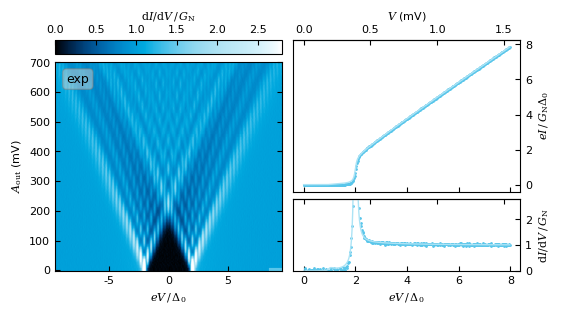

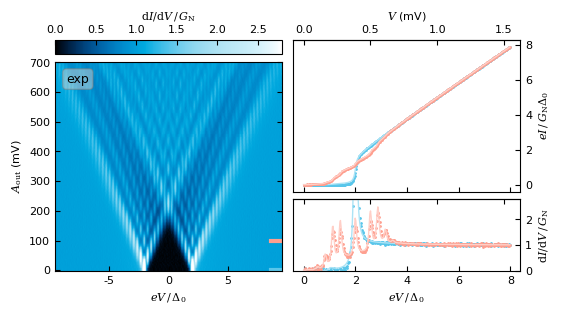

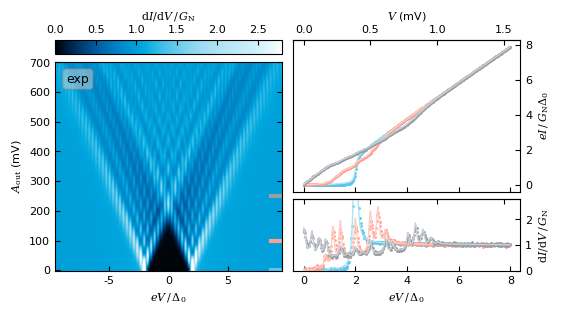

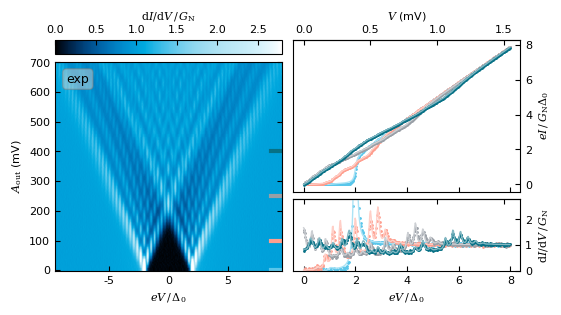

In [7]:
# plot map comparison sim/exp


def VtoE(V_mV):
    return V_mV / Delta_0_meV


def EtoV(E_meV):
    return E_meV * Delta_0_meV


V_label = r"$eV\,/\,\Delta_0$"
E_label = r"$V$ (mV)"
I_label = r"$eI\,/\,G_\mathrm{N}\Delta_0$"
G_label = r"$\mathrm{d}I/\mathrm{d}V\,/\,G_\mathrm{N}$"
y_label = r"$A_\mathrm{out}$ (mV)"

index0 = np.argmin(np.abs(V_mV / Delta_0_meV))
index1 = np.argmin(np.abs(V_mV / Delta_0_meV - 8))
img_z = np.concatenate((G_exp_G0[:, 1:index0], G_exp_G0[:, index0:]), axis=1)
img_x = V_mV / Delta_0_meV
img_y = A_out_mV

dx, dy = img_x[-1] - img_x[-2], img_y[-1] - img_y[-2]
ext = (img_x[0] - dx / 2, img_x[-1] + dx / 2, img_y[0] - dy / 2, img_y[-1] + dy / 2)
clim = (
    np.nanmean(img_z) - 2 * np.nanstd(img_z),
    np.nanmean(img_z) + 2 * np.nanstd(img_z),
)
clim = (0, 2.8)


A_indices = []
for A_in in A_interest_mV:
    A_indices.append(np.argmin(np.abs(img_y - A_in)))

for j in range(len(A_interest_mV)):
    # fig and axs
    fig, axs = plt.subplots(
        figsize=(6, 3),
        nrows=3,
        ncols=2,
        height_ratios=(0.2, 1.8, 1),
        # sharex = True
    )
    plt.subplots_adjust(hspace=0.1, wspace=0.05)
    ax_clb = axs[0, 0]

    gs = axs[0, 1].get_gridspec()
    for ax in axs[1:, 0]:
        ax.remove()
    ax_img = fig.add_subplot(gs[1:, 0])

    gs = axs[1, 0].get_gridspec()
    for ax in axs[:2, 1]:
        ax.remove()
    ax_i = fig.add_subplot(gs[:2, 1])

    ax_g = axs[2, 1]

    for ax in [ax_clb, ax_img, ax_i, ax_g]:
        ax.tick_params(
            direction="in",  # Ticks nach innen
            top=False,  # obere Ticks ein
            bottom=True,  # untere Ticks ein
            left=True,  # linke Ticks ein
            right=True,  # rechte Ticks ein
            which="both",  # sowohl Major- als auch Minor-Ticks
        )

    im = ax_img.imshow(
        img_z,
        aspect="auto",
        origin="lower",
        clim=clim,
        extent=ext,
        interpolation=None,
        cmap=cmap(bad="grey"),
    )
    # ax_img.vlines(0, ymin=ext[2], ymax=ext[3], color="k")

    cbar = fig.colorbar(
        im,
        cax=ax_clb,
        label=G_label,
        orientation="horizontal",
        location="top",
    )

    ax_img_xlim = ax_img.get_xlim()
    for i, A_i in enumerate(A_indices[: j + 1]):
        color_exp = colors(i)
        color_fit = colors(i, 0.5)
        ax_i.plot(
            img_x[index0:index1], I_exp[A_i, index0:index1], ".", ms=2, color=color_exp
        )
        ax_i.plot(img_x[index0:index1], I_fit[A_i, index0:index1], "-", color=color_fit)
        ax_g.plot(
            img_x[index0:index1],
            G_exp_G0[A_i, index0:index1],
            ".",
            ms=2,
            color=color_exp,
        )
        ax_g.plot(
            img_x[index0:index1], G_fit_G0[A_i, index0:index1], "-", color=color_fit
        )
        ax_img.plot(
            (ax_img_xlim[1] * 0.9, ax_img_xlim[1]),
            (A_out_mV[A_i], A_out_mV[A_i]),
            color=color_exp,
            lw=3,
        )

    ax_i_2 = ax_i.secondary_xaxis("top", functions=(EtoV, VtoE))
    ax_i_2.tick_params(direction="in", top=True)
    ax_g_2 = ax_g.secondary_xaxis("top", functions=(EtoV, VtoE))
    ax_g_2.tick_params(direction="in", top=True)

    ax_i.xaxis.set_ticklabels([])
    ax_g_2.xaxis.set_ticklabels([])

    ax_g.yaxis.set_label_position("right")
    ax_g.yaxis.tick_right()
    ax_g.set_ylim(clim)

    ax_i.yaxis.set_label_position("right")
    ax_i.yaxis.tick_right()

    ax_img.set_ylabel(y_label)
    ax_img.set_xlabel(V_label)
    ax_g.set_xlabel(V_label)
    ax_g.set_ylabel(G_label)
    ax_i_2.set_xlabel(E_label)
    ax_i.set_ylabel(I_label)

    # add text box for the statistics
    bbox = dict(boxstyle="round", fc="lightgrey", ec="grey", alpha=0.5)

    ax_img.text(0.05, 0.9, "exp", fontsize=9, bbox=bbox, transform=ax_img.transAxes)
    # ax_img.text(0.85, 0.9, "fit", fontsize=9, bbox=bbox, transform=ax_img.transAxes)

    fig.savefig(
        f"exp_{j}_{nu_GHz}GHz.png",
        dpi=600,
        transparent=True,
        facecolor="none",
        edgecolor="none",
    )

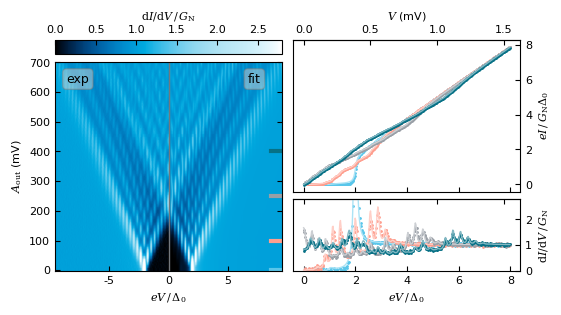

In [8]:
# plot map comparison exp/fit


def VtoE(V_mV):
    return V_mV / Delta_0_meV


def EtoV(E_meV):
    return E_meV * Delta_0_meV


V_label = r"$eV\,/\,\Delta_0$"
E_label = r"$V$ (mV)"
I_label = r"$eI\,/\,G_\mathrm{N}\Delta_0$"
G_label = r"$\mathrm{d}I/\mathrm{d}V\,/\,G_\mathrm{N}$"
y_label = r"$A_\mathrm{out}$ (mV)"

index0 = np.argmin(np.abs(V_mV / Delta_0_meV))
index1 = np.argmin(np.abs(V_mV / Delta_0_meV - 8))
img_z = np.concatenate((G_exp_G0[:, 1:index0], G_fit_G0[:, index0:]), axis=1)
img_x = V_mV / Delta_0_meV
img_y = A_out_mV

dx, dy = img_x[-1] - img_x[-2], img_y[-1] - img_y[-2]
ext = (img_x[0] - dx / 2, img_x[-1] + dx / 2, img_y[0] - dy / 2, img_y[-1] + dy / 2)
clim = (
    np.nanmean(img_z) - 2 * np.nanstd(img_z),
    np.nanmean(img_z) + 2 * np.nanstd(img_z),
)
clim = (0, 2.8)

A_indices = []
for A_in in A_interest_mV:
    A_indices.append(np.argmin(np.abs(img_y - A_in)))

# fig and axs
fig, axs = plt.subplots(
    figsize=(6, 3),
    nrows=3,
    ncols=2,
    height_ratios=(0.2, 1.8, 1),
    # sharex = True
)
plt.subplots_adjust(hspace=0.1, wspace=0.05)
ax_clb = axs[0, 0]

gs = axs[0, 1].get_gridspec()
for ax in axs[1:, 0]:
    ax.remove()
ax_img = fig.add_subplot(gs[1:, 0])

gs = axs[1, 0].get_gridspec()
for ax in axs[:2, 1]:
    ax.remove()
ax_i = fig.add_subplot(gs[:2, 1])

ax_g = axs[2, 1]

for ax in [ax_clb, ax_img, ax_i, ax_g]:
    ax.tick_params(
        direction="in",  # Ticks nach innen
        top=False,  # obere Ticks ein
        bottom=True,  # untere Ticks ein
        left=True,  # linke Ticks ein
        right=True,  # rechte Ticks ein
        which="both",  # sowohl Major- als auch Minor-Ticks
    )


im = ax_img.imshow(
    img_z,
    aspect="auto",
    origin="lower",
    clim=clim,
    extent=ext,
    interpolation=None,
    cmap=cmap(bad="grey"),
)
ax_img.vlines(0, ymin=ext[2], ymax=ext[3], color=sc.seegrau100)

cbar = fig.colorbar(
    im,
    cax=ax_clb,
    label=G_label,
    orientation="horizontal",
    location="top",
)

ax_img_xlim = ax_img.get_xlim()
for i, A_i in enumerate(A_indices):
    color_exp = colors(i)
    color_fit = colors(i, 0.5)
    ax_i.plot(
        img_x[index0:index1], I_exp[A_i, index0:index1], ".", ms=2, color=color_exp
    )
    ax_i.plot(img_x[index0:index1], I_fit[A_i, index0:index1], "-", color=color_fit)
    ax_g.plot(
        img_x[index0:index1], G_exp_G0[A_i, index0:index1], ".", ms=2, color=color_exp
    )
    ax_g.plot(img_x[index0:index1], G_fit_G0[A_i, index0:index1], "-", color=color_fit)
    ax_img.plot(
        (ax_img_xlim[1] * 0.9, ax_img_xlim[1]),
        (A_out_mV[A_i], A_out_mV[A_i]),
        color=color_exp,
        lw=3,
    )


ax_i_2 = ax_i.secondary_xaxis("top", functions=(EtoV, VtoE))
ax_i_2.tick_params(direction="in", top=True)
ax_g_2 = ax_g.secondary_xaxis("top", functions=(EtoV, VtoE))
ax_g_2.tick_params(direction="in", top=True)

ax_i.xaxis.set_ticklabels([])
ax_g_2.xaxis.set_ticklabels([])

ax_g.yaxis.set_label_position("right")
ax_g.yaxis.tick_right()
ax_g.set_ylim(clim)

ax_i.yaxis.set_label_position("right")
ax_i.yaxis.tick_right()

ax_img.set_ylabel(y_label)
ax_img.set_xlabel(V_label)
ax_g.set_xlabel(V_label)
ax_g.set_ylabel(G_label)
ax_i_2.set_xlabel(E_label)
ax_i.set_ylabel(I_label)

# add text box for the statistics
bbox = dict(boxstyle="round", fc="lightgrey", ec="grey", alpha=0.5)

ax_img.text(0.05, 0.9, "exp", fontsize=9, bbox=bbox, transform=ax_img.transAxes)
ax_img.text(0.85, 0.9, "fit", fontsize=9, bbox=bbox, transform=ax_img.transAxes)

fig.savefig(
    f"exp_fit_{nu_GHz}GHz.png",
    dpi=600,
    transparent=True,
    facecolor="none",
    edgecolor="none",
)

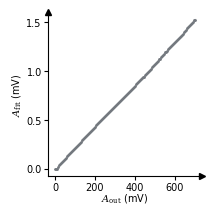

In [9]:
A_fit_err_mV[0] = 0.0
A_fit_err_mV[1] = 0.0
A_fit_err_mV[2] = 0.0

fig, ax = sc.get_figure(figsize=(2.0, 2.0), padding=(0.3, 0.2))

for i, a_fit_err_mV in enumerate(A_fit_err_mV):

    ax.plot(
        (A_out_mV[i], A_out_mV[i]),
        (
            A_fit_mV[i] - A_fit_err_mV[i],
            A_fit_mV[i] + A_fit_err_mV[i],
        ),
        "-",
        lw=1,
        color=sc.seegrau20,
    )

ax.plot(
    A_out_mV,
    A_fit_mV,
    ".",
    ms=2,
    color=sc.seegrau100,
)
ax.set_yticks([0, 0.5, 1, 1.5])

xlabel = r"$A_\mathrm{out}$ (mV)"
ylabel = r"$A_\mathrm{fit}$ (mV)"
title = None

sc.theory_layout(fig, ax, title, xlabel, ylabel)
fig.savefig(
    f"exp_{nu_GHz}GHz_Acal_data.png",
    dpi=600,
    transparent=True,
    facecolor="none",
    edgecolor="none",
)

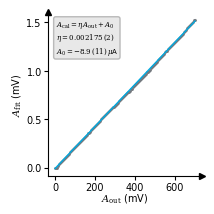

In [10]:
A_fit_err_mV[0] = 0.0
A_fit_err_mV[1] = 0.0
A_fit_err_mV[2] = 0.0

fig, ax = sc.get_figure(figsize=(2.0, 2.0), padding=(0.3, 0.2))

for i, a_fit_err_mV in enumerate(A_fit_err_mV):

    ax.plot(
        (A_out_mV[i], A_out_mV[i]),
        (
            A_fit_mV[i] - A_fit_err_mV[i],
            A_fit_mV[i] + A_fit_err_mV[i],
        ),
        "-",
        lw=1,
        color=sc.seegrau20,
    )

ax.plot(
    A_out_mV,
    A_fit_mV,
    ".",
    ms=2,
    color=sc.seegrau100,
)

mask = np.bool(np.ones_like(A_out_mV))

A_popt, A_pcov = curve_fit(
    f=calibration_A,
    xdata=np.array(A_out_mV[mask], dtype="float64"),
    ydata=np.array(A_fit_mV[mask], dtype="float64"),
)
A_perr = np.sqrt(np.diag(A_pcov))
A_cal_mV = calibration_A(A_out_mV, *A_popt)

ax.plot(A_out_mV, A_cal_mV, color=sc.seeblau100)
ax.set_yticks([0, 0.5, 1, 1.5])


stats = (
    "$A_\\mathrm{cal} = \eta\\, A_\\mathrm{out} + A_0$ \n"
    "$\eta$"
    f"$={A_popt[0]:.6f}\\,({int(A_perr[0]*1e6)})\\,$\n"
    "$A_0 = $"
    f"${A_popt[1]*1e3:.1f}\\,({int(A_perr[1]*1e4)})\\,\\mu$A"
)
bbox = dict(boxstyle="round", fc="lightgrey", ec="grey", alpha=0.5)
ax.text(
    0.05,
    0.75,
    stats,
    fontsize=5,
    bbox=bbox,
    transform=ax.transAxes,
    horizontalalignment="left",
)

xlabel = r"$A_\mathrm{out}$ (mV)"
ylabel = r"$A_\mathrm{fit}$ (mV)"
title = None

sc.theory_layout(fig, ax, title, xlabel, ylabel)
fig.savefig(
    f"exp_{nu_GHz}GHz_Acal_fit.png",
    dpi=600,
    transparent=True,
    facecolor="none",
    edgecolor="none",
)

(0.0, 1.498)

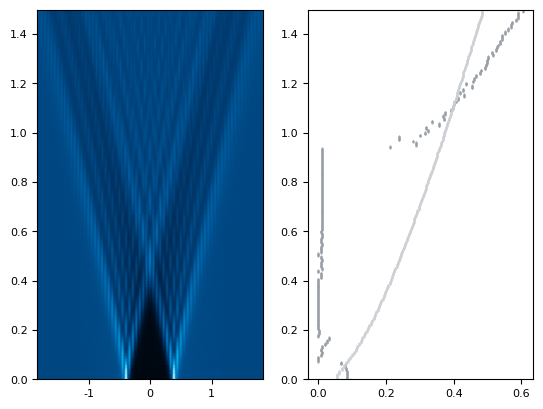

In [11]:
# bin over A_fit


# region pre-definitions
def bin_z_over_y(y: np.ndarray, z: np.ndarray, y_binned: np.ndarray):
    """
    Bin z-values over y-values using predefined bins.
    If a bin receives no data, fill it from the previous valid bin above (top-down fill).

    Parameters
    ----------
    y : np.ndarray
        Y-values to be binned.
    z : np.ndarray
        Corresponding Z-values (2D array with shape (N, M)).
    y_binned : np.ndarray
        Bin edges for y-values.

    Returns
    -------
    tuple
        Binned z-values (2D), and count of points in each bin.
    """
    number_of_bins = len(y_binned)
    counter = np.zeros(number_of_bins, dtype=int)
    result = np.zeros((number_of_bins, z.shape[1]), dtype=float)

    # Assign y-values to bins
    dig = np.digitize(y, bins=y_binned) - 1
    valid_indices = (dig >= 0) & (dig < number_of_bins)

    # Count entries and sum z-values into bins
    np.add.at(counter, dig[valid_indices], 1)
    np.add.at(result, dig[valid_indices], z[valid_indices])

    # Average values where data exists
    with np.errstate(invalid="ignore"):  # Suppress divide-by-zero warnings
        result[counter > 0] /= counter[counter > 0, None]
        result[counter == 0] = np.nan  # Mark empty bins as NaN
    return result


def fill_nans(arr, mode="both", axis=0):
    """
    Fill NaN values in a 1D or 2D array by propagating values from top/down or averaging both.

    Parameters
    ----------
    arr : np.ndarray
        Input array (1D or 2D) containing NaNs.
    mode : {"top", "down", "both"}, optional
        Direction to fill from:
        - "top": fill NaNs downward (like forward fill)
        - "down": fill NaNs upward (like backward fill)
        - "both": fill NaNs by averaging top & down fills
    axis : int, optional
        If arr is 2D:
        - axis=0 fills along rows (top-down per column)
        - axis=1 fills along columns (left-right per row)

    Returns
    -------
    filled : np.ndarray
        Array with NaNs replaced.
    """
    arr = np.asarray(arr, dtype=float)
    filled = arr.copy()

    if arr.ndim == 1:
        filled = _fill_1d(arr, mode)
    elif arr.ndim == 2:
        if axis == 1:
            filled = np.apply_along_axis(_fill_1d, 1, arr, mode)
        else:
            filled = np.apply_along_axis(_fill_1d, 0, arr, mode)
    else:
        raise ValueError("Only 1D or 2D arrays are supported.")

    return filled


def _fill_1d(vec, mode):
    """Helper: fill a 1D vector with NaNs using top/down/both strategy."""
    v = np.asarray(vec, dtype=float)
    n = len(v)

    # Forward (top) fill
    top = v.copy()
    mask = np.isnan(top)
    idx = np.where(~mask, np.arange(n), 0)
    np.maximum.accumulate(idx, out=idx)
    top[mask] = top[idx[mask]]

    # Backward (down) fill
    down = v.copy()
    mask = np.isnan(down)
    idx = np.where(~mask, np.arange(n), n - 1)
    np.minimum.accumulate(idx[::-1], out=idx[::-1])
    down[mask] = down[idx[mask]]

    if mode == "top":
        return top
    elif mode == "down":
        return down
    elif mode == "both":
        return np.nanmean(np.stack([top, down]), axis=0)
    else:
        raise ValueError("mode must be 'top', 'down', or 'both'")


# endregion

I_binA_exp_nA = bin_z_over_y(A_fit_mV, I_exp_nA, A_mV)
I_binA_exp_nA = fill_nans(I_binA_exp_nA, mode="down", axis=0)

I_binA_exp = I_binA_exp_nA / (tau_0_arbu * G_0_muS * Delta_0_meV)
G_binA_exp_G0 = np.gradient(I_binA_exp_nA, V_mV, axis=1) / (tau_0_arbu * G_0_muS)

T_binA_fit_K = bin_y_over_x(A_fit_mV, T_fit_K, A_mV)
T_binA_fit_K = fill_nans(T_binA_fit_K, mode="down")

T_binA_fit_err_K = bin_y_over_x(A_fit_mV, T_fit_err_K, A_mV)
T_binA_fit_err_K = fill_nans(T_binA_fit_err_K, mode="down")

T_binA_exp_K = bin_y_over_x(A_fit_mV, T_exp_K, A_mV)
T_binA_exp_K = fill_nans(T_binA_exp_K, mode="down")

# region show binned data
fig, [ax0, ax1] = plt.subplots(1, 2)

ax0.imshow(
    G_binA_exp_G0,
    aspect="auto",
    origin="lower",
    cmap=cmap(),
    extent=(min(V_mV), max(V_mV), min(A_mV), max(A_mV)),
)

ax1.plot(T_binA_fit_K, A_mV, ".", color=colors(2))
ax1.plot(T_binA_exp_K, A_mV, ".", color=colors(2, 0.5))
ax1.set_ylim((min(A_mV), max(A_mV)))
# endregion

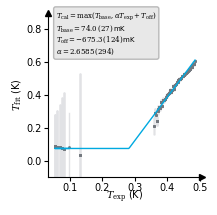

In [12]:
import superconductivity.api as sc

fig, ax = sc.get_figure(figsize=(2.0, 2.0), padding=(0.3, 0.2))

mask = T_binA_fit_K >= 0.03

for i, t_fit_err_mV in enumerate(T_binA_fit_err_K):

    if mask[i]:
        ax.plot(
            (T_binA_exp_K[i], T_binA_exp_K[i]),
            (
                T_binA_fit_K[i] - T_binA_fit_err_K[i],
                T_binA_fit_K[i] + T_binA_fit_err_K[i],
            ),
            "-",
            lw=1,
            color=sc.seegrau20,
        )


ax.plot(
    T_binA_exp_K[mask],
    T_binA_fit_K[mask],
    ".",
    ms=2,
    color=sc.seegrau100,
)


T_popt, T_pcov = curve_fit(
    f=calibration_T,
    xdata=np.array(T_binA_exp_K[mask], dtype="float64"),
    ydata=np.array(T_binA_fit_K[mask], dtype="float64"),
)
T_perr = np.sqrt(np.diag(T_pcov))
T_binA_cal_K = calibration_T(T_binA_exp_K, T_popt[0], T_popt[1], T_popt[2])
ax.plot(T_binA_exp_K, T_binA_cal_K, color=sc.seeblau100)

ax.set_ylim(-0.1, 0.9)

xlabel = r"$T_\mathrm{exp}$ (K)"
ylabel = r"$T_\mathrm{fit}$ (K)"
title = None

stats = (
    "$T_\\mathrm{cal} = \\mathrm{max}(T_\\mathrm{base}, \\alpha T_\\mathrm{exp}+T_\\mathrm{off})$ \n"
    "$T_\\mathrm{base}$"
    f"$={T_popt[0]*1e3:.1f}\\,({int(T_perr[0]*1e4)})\\,$mK\n"
    "$T_\\mathrm{off} = $"
    f"${T_popt[1]*1e3:.1f}\\,({int(T_perr[1]*1e4)})\\,$mK\n"
    f"$\\alpha={T_popt[2]:.4f}\\,({int(T_perr[2]*1e4)})\\,$"
)
bbox = dict(boxstyle="round", fc="lightgrey", ec="grey", alpha=0.5)
ax.text(
    0.05,
    0.75,
    stats,
    fontsize=5,
    bbox=bbox,
    transform=ax.transAxes,
    horizontalalignment="left",
)

sc.theory_layout(fig, ax, title, xlabel, ylabel)

fig.savefig(
    f"exp_{nu_GHz}GHz_Tcal.png",
    dpi=600,
    transparent=True,
    facecolor="none",
    edgecolor="none",
)

In [13]:
# Simulation

from superconductivity.optimizers.models import get_model

get_I_pat_nA, _ = get_model(model="pat")

I_binA_sim_nA = np.copy(I_binA_exp_nA)
I_binA_sim = np.copy(I_binA_exp)
G_binA_sim_G0 = np.copy(G_binA_exp_G0)

for i, a_mV in enumerate(tqdm(A_mV)):
    I_pat_nA = get_I_pat_nA(
        V_mV=V_mV,
        G_N=tau_0_arbu,
        T_K=T_binA_cal_K[i],
        Delta_mV=Delta_0_meV,
        gamma_meV=Gamma_0_meV,
        A_mV=a_mV,
        nu_GHz=nu_GHz,
    )
    I_pat = I_pat_nA / (tau_0_arbu * G_0_muS * Delta_0_meV)
    G_pat_G0 = np.gradient(I_pat_nA, V_mV) / (tau_0_arbu * G_0_muS)

    I_binA_sim_nA[i, :] = I_pat_nA
    I_binA_sim[i, :] = I_pat
    G_binA_sim_G0[i, :] = G_pat_G0

100%|██████████| 750/750 [01:46<00:00,  7.07it/s]


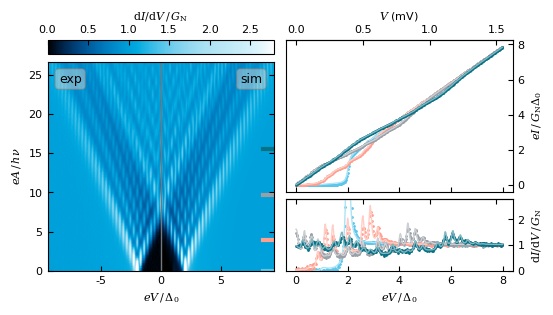

In [19]:
# plot map comparison sim/exp


def VtoE(V_mV):
    return V_mV / Delta_0_meV


def EtoV(E_meV):
    return E_meV * Delta_0_meV


V_label = r"$eV\,/\,\Delta_0$"
E_label = r"$V$ (mV)"
I_label = r"$eI\,/\,G_\mathrm{N}\Delta_0$"
G_label = r"$\mathrm{d}I/\mathrm{d}V\,/\,G_\mathrm{N}$"
y_label = r"$eA\,/\,h\nu$"

index0 = np.argmin(np.abs(V_mV / Delta_0_meV))
index1 = np.argmin(np.abs(V_mV / Delta_0_meV - 8))
img_z = np.concatenate((G_binA_exp_G0[:, 1:index0], G_binA_sim_G0[:, index0:]), axis=1)
img_x = V_mV / Delta_0_meV
img_y = A_mV / (sc.h_e_pVs * nu_GHz)

dx, dy = img_x[-1] - img_x[-2], img_y[-1] - img_y[-2]
ext = (img_x[0] - dx / 2, img_x[-1] + dx / 2, img_y[0] - dy / 2, img_y[-1] + dy / 2)
clim = (
    np.nanmean(img_z) - 2 * np.nanstd(img_z),
    np.nanmean(img_z) + 2 * np.nanstd(img_z),
)
clim = (0, 2.8)

A_indices = []
A_interest = np.array(A_interest_mV) * A_popt[0] / (sc.h_e_pVs * nu_GHz)
for A_in in A_interest:
    A_indices.append(np.argmin(np.abs(img_y - A_in)))

# fig and axs
fig, axs = plt.subplots(
    figsize=(6, 3),
    nrows=3,
    ncols=2,
    height_ratios=(0.2, 1.8, 1),
    # sharex = True
)
plt.subplots_adjust(hspace=0.1, wspace=0.05)
ax_clb = axs[0, 0]

gs = axs[0, 1].get_gridspec()
for ax in axs[1:, 0]:
    ax.remove()
ax_img = fig.add_subplot(gs[1:, 0])

gs = axs[1, 0].get_gridspec()
for ax in axs[:2, 1]:
    ax.remove()
ax_i = fig.add_subplot(gs[:2, 1])

ax_g = axs[2, 1]

for ax in [ax_clb, ax_img, ax_i, ax_g]:
    ax.tick_params(
        direction="in",  # Ticks nach innen
        top=False,  # obere Ticks ein
        bottom=True,  # untere Ticks ein
        left=True,  # linke Ticks ein
        right=True,  # rechte Ticks ein
        which="both",  # sowohl Major- als auch Minor-Ticks
    )


im = ax_img.imshow(
    img_z,
    aspect="auto",
    origin="lower",
    clim=clim,
    extent=ext,
    interpolation=None,
    cmap=cmap(bad="grey"),
)
ax_img.vlines(0, ymin=ext[2], ymax=ext[3], color=sc.seegrau100)

cbar = fig.colorbar(
    im,
    cax=ax_clb,
    label=G_label,
    orientation="horizontal",
    location="top",
)

ax_img_xlim = ax_img.get_xlim()
for i, A_i in enumerate(A_indices):
    color_exp = colors(i)
    color_fit = colors(i, 0.5)
    ax_i.plot(
        img_x[index0:index1],
        I_binA_exp[A_i, index0:index1],
        ".",
        ms=2,
        color=color_exp,
    )
    ax_i.plot(
        img_x[index0:index1], I_binA_sim[A_i, index0:index1], "-", color=color_fit
    )
    ax_g.plot(
        img_x[index0:index1],
        G_binA_exp_G0[A_i, index0:index1],
        ".",
        ms=2,
        color=color_exp,
    )
    ax_g.plot(
        img_x[index0:index1],
        G_binA_sim_G0[A_i, index0:index1],
        "-",
        color=color_fit,
    )
    ax_img.plot(
        (ax_img_xlim[1] * 0.9, ax_img_xlim[1]),
        (img_y[A_i], img_y[A_i]),
        color=color_exp,
        lw=3,
    )


ax_i_2 = ax_i.secondary_xaxis("top", functions=(EtoV, VtoE))
ax_i_2.tick_params(direction="in", top=True)
ax_g_2 = ax_g.secondary_xaxis("top", functions=(EtoV, VtoE))
ax_g_2.tick_params(direction="in", top=True)

ax_i.xaxis.set_ticklabels([])
ax_g_2.xaxis.set_ticklabels([])

ax_g.yaxis.set_label_position("right")
ax_g.yaxis.tick_right()
ax_g.set_ylim(clim)

ax_i.yaxis.set_label_position("right")
ax_i.yaxis.tick_right()

ax_img.set_ylabel(y_label)
ax_img.set_xlabel(V_label)
ax_g.set_xlabel(V_label)
ax_g.set_ylabel(G_label)
ax_i_2.set_xlabel(E_label)
ax_i.set_ylabel(I_label)


# add text box for the statistics
bbox = dict(boxstyle="round", fc="lightgrey", ec="grey", alpha=0.5)

ax_img.text(0.05, 0.9, "exp", fontsize=9, bbox=bbox, transform=ax_img.transAxes)
ax_img.text(0.85, 0.9, "sim", fontsize=9, bbox=bbox, transform=ax_img.transAxes)

fig.savefig(
    f"exp_sim_{nu_GHz}GHz.png",
    dpi=600,
    transparent=True,
    facecolor="none",
    edgecolor="none",
)